
# Deep Neural Networks for Energy Forecasting


In this notebook, we will apply deep learning using PyTorch to a real-world energy use case:  
**Predicting backup generator activation for data centers based on environmental and operational variables**.

We will build and train several deep neural networks, compare activation functions, and evaluate model performance.

###  Step 0: Import Required Libraries
In this step, we import all necessary libraries for deep learning, data preprocessing, and model evaluation. These include PyTorch for model building, NumPy for numerical operations, pandas for data handling, Matplotlib for plotting, and scikit-learn for preprocessing and metrics.

In [1]:
# import essential libraries for deep learning, data handling, and visualization
import torch
import torch.nn as nn  # for building neural network layers
import torch.optim as optim  # for optimization algorithms
import numpy as np  # for numerical operations on arrays
import pandas as pd  # for data manipulation using DataFrames
import matplotlib.pyplot as plt  # for plotting graphs

# import scikit-learn modules for preprocessing, splitting data, and evaluating models
from sklearn.model_selection import train_test_split  # to split dataset into training and test sets
from sklearn.preprocessing import StandardScaler  # to normalize features
from sklearn.metrics import accuracy_score  # to evaluate classification performance

### Step 1: Simulate Real-World Energy Data

We begin by generating synthetic data that mimics real-world energy system conditions. Each feature represents a measurable parameter like fuel level, grid load, or temperature. The target is a binary label indicating whether a generator should start based on certain thresholds.

In [2]:

np.random.seed(0)

n_samples = 5000
X = pd.DataFrame({
    "grid_load_kw": np.random.normal(400, 100, n_samples),
    "fuel_pct_remaining": np.random.uniform(0.1, 1.0, n_samples),
    "temperature_c": np.random.normal(27, 5, n_samples),
    "humidity_pct": np.random.uniform(20, 90, n_samples),
    "wind_speed_kph": np.random.normal(15, 5, n_samples),
    "solar_irradiance_wm2": np.random.uniform(0, 1000, n_samples),
    "main_grid_stability_score": np.random.uniform(0.4, 1.0, n_samples),
    "minutes_since_last_start": np.random.randint(0, 180, n_samples)
})

# Binary target: generator starts when fuel is low, grid is unstable, or temp is high
y = ((X["fuel_pct_remaining"] < 0.3) & 
     (X["main_grid_stability_score"] < 0.6) & 
     (X["temperature_c"] > 30)).astype(int)

print(X.head())
print("Target distribution:", y.value_counts().to_dict())


   grid_load_kw  fuel_pct_remaining  temperature_c  humidity_pct  \
0    576.405235            0.196431      24.986506     77.998120   
1    440.015721            0.698495      29.960229     29.092432   
2    497.873798            0.470853      27.045283     55.754007   
3    624.089320            0.333653      22.568391     33.109508   
4    586.755799            0.641756      27.245499     87.869337   

   wind_speed_kph  solar_irradiance_wm2  main_grid_stability_score  \
0       16.382952            926.602172                   0.832054   
1       18.201776            845.790351                   0.961334   
2       12.487296            910.229467                   0.536925   
3       17.961767            906.180825                   0.460292   
4       18.239310            881.988671                   0.510391   

   minutes_since_last_start  
0                        15  
1                       128  
2                       120  
3                        25  
4                   

### Step 2: Data Preprocessing

Before training, we normalize input features to ensure faster convergence and better performance. The dataset is then split into training and test sets, and all arrays are converted into PyTorch tensors to be compatible with the training pipeline.

In [3]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split the data 20% test, 80% train
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

input_dim = X_train.shape[1]


### Step 3: Define Deep Neural Network


Here we define our neural network model by subclassing `nn.Module`. The `__init__` method defines the layers, and the `forward` method defines how data passes through them.

In [4]:
# define a simple feedforward neural network architecture with custom activation
class PowerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(PowerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation_fn = activation_fn  # store activation function

    def forward(self, x):
        # apply custom activation to the first layer
        x = self.activation_fn(self.fc1(x))
        # second layer (no activation; BCEWithLogitsLoss expects raw output)
        x = torch.sigmoid(self.fc2(x))

        return x


### Step 4: Training Function

This function handles the model training loop over multiple epochs. It tracks both training loss and validation accuracy, performing backpropagation and optimization on the training data and evaluation on the test set after each epoch.

In [5]:

def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, epochs=200):
    loss_list, acc_list = [], []

    for epoch in range(epochs):
        model.train()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test)
            preds = (y_test_pred > 0.5).float()
            acc = accuracy_score(y_test.numpy(), preds.numpy())

        loss_list.append(loss.item())
        acc_list.append(acc)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}, Accuracy = {acc:.4f}")

    return loss_list, acc_list


### Step 5: Compare Activation Functions

To explore how different activation functions affect model learning, we define a dictionary of options and train the model separately with each one. We record the loss and accuracy for comparison across activation functions.

In [6]:

results = {}
criterion = nn.BCELoss()
epochs = 200

activations = {
    "Sigmoid": torch.sigmoid,
    "Tanh": torch.tanh,
    "ReLU": torch.relu
}

for name, fn in activations.items():
    print(f"\nTraining with {name}")
    model = PowerNet(input_dim, 32, 1, fn)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss, acc = train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, epochs)
    results[name] = {"loss": loss, "acc": acc}



Training with Sigmoid
Epoch 20: Loss = 0.1182, Accuracy = 0.9810
Epoch 40: Loss = 0.0730, Accuracy = 0.9810
Epoch 60: Loss = 0.0632, Accuracy = 0.9810
Epoch 80: Loss = 0.0585, Accuracy = 0.9810
Epoch 100: Loss = 0.0554, Accuracy = 0.9810
Epoch 120: Loss = 0.0530, Accuracy = 0.9810
Epoch 140: Loss = 0.0510, Accuracy = 0.9810
Epoch 160: Loss = 0.0493, Accuracy = 0.9810
Epoch 180: Loss = 0.0478, Accuracy = 0.9810
Epoch 200: Loss = 0.0463, Accuracy = 0.9810

Training with Tanh
Epoch 20: Loss = 0.2178, Accuracy = 0.9810
Epoch 40: Loss = 0.0677, Accuracy = 0.9820
Epoch 60: Loss = 0.0490, Accuracy = 0.9820
Epoch 80: Loss = 0.0429, Accuracy = 0.9820
Epoch 100: Loss = 0.0394, Accuracy = 0.9820
Epoch 120: Loss = 0.0370, Accuracy = 0.9820
Epoch 140: Loss = 0.0351, Accuracy = 0.9830
Epoch 160: Loss = 0.0335, Accuracy = 0.9840
Epoch 180: Loss = 0.0320, Accuracy = 0.9830
Epoch 200: Loss = 0.0306, Accuracy = 0.9830

Training with ReLU
Epoch 20: Loss = 0.1268, Accuracy = 0.9810
Epoch 40: Loss = 0.070

### Step 6: Visualize Results

Finally, we plot the training loss and validation accuracy curves for each activation function. These visualizations help us analyze model behavior and determine which activation function performs best over time.

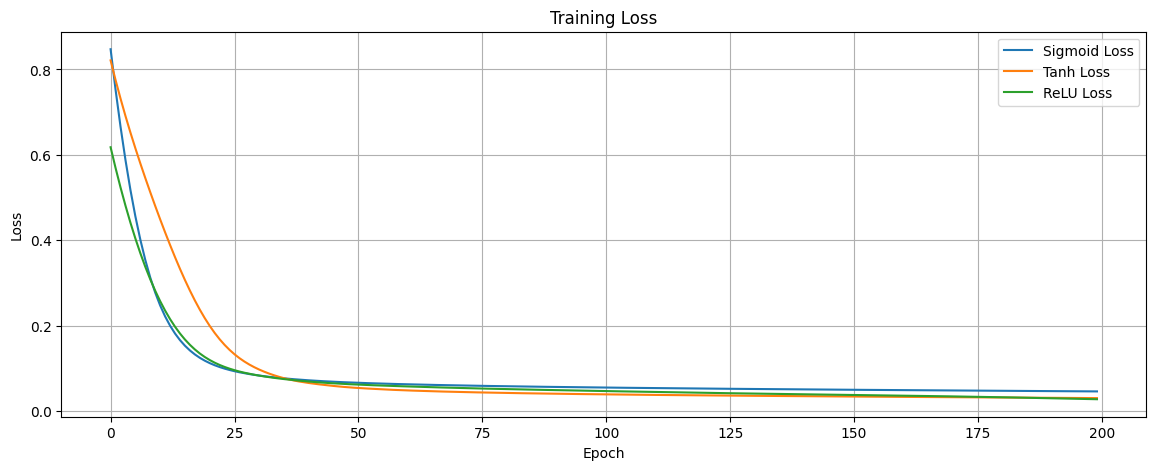

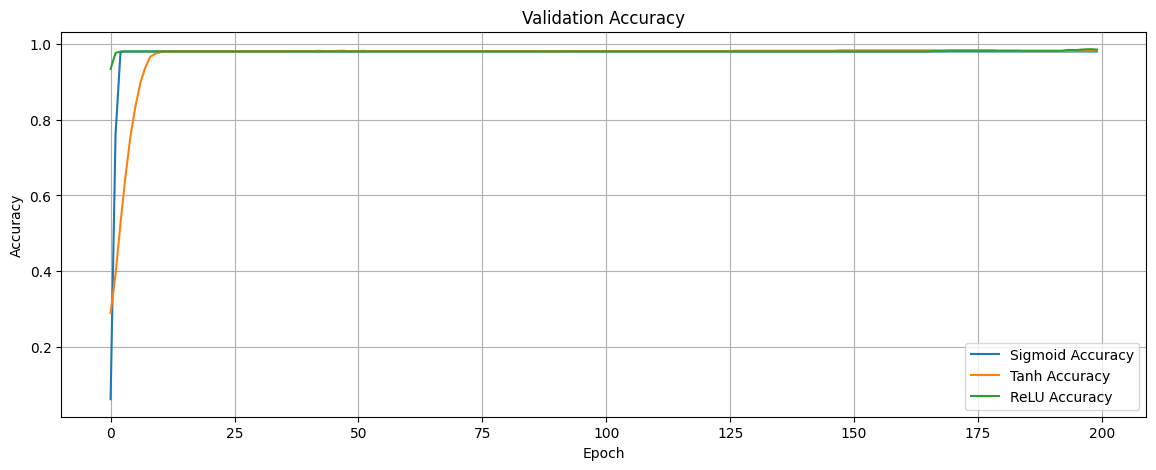

In [7]:

plt.figure(figsize=(14,5))
for name in results:
    plt.plot(results[name]["loss"], label=f"{name} Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,5))
for name in results:
    plt.plot(results[name]["acc"], label=f"{name} Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Conclusion

This experiment demonstrated how different activation functions—Sigmoid, Tanh, and ReLU—influence a neural network’s training dynamics. While all three functions eventually achieve high accuracy on this clean, synthetic dataset, ReLU consistently converges faster and achieves superior early performance in both loss reduction and validation accuracy. This is expected, as ReLU avoids vanishing gradient issues common with Sigmoid and Tanh, making it the most efficient choice in deep learning practice.

To further explore this behavior, try adjusting parameters such as:

- Number of training samples (n_samples)

- Noise in the dataset (np.random.normal spreads)

- Hidden layer sizes or number of layers

- Learning rate (lr)

- Number of epochs

- Batch size (if mini-batching is introduced)

These changes will showcase ReLU’s robustness and scalability, especially as tasks become more complex or datasets become noisier.